In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bitcoin-historical-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1346%2F2109006%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T022707Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3920ae9641eb4a55d4498758246949d21d57beb160817c42520deb80d37e0de9e6b71b97dd5a2812aaad1be57ec95cdb0a128df3f482df8e76976b290102eb9a472f3a174aa7c13df1d25019fcaec19c60cab8e411cf8e676a2ceb18615b32a7466adaf5ba297883a38794279f80d40450606be338bfbea352676b86b1513500df921a61b9cd052d69abaf4ea9649942d09de6e8c3094779ec7e3de22c05e0db5b956b44ed338dcbf5041af09b9aa3b7fd026eb0bd4ae1a0584515341281e30c68853ad47e24c0d01f09511510f3c69e85f1990874d32d49ac119bc04b939afd74987c55f18f07d1e46c105c53496124148b16c280975bb711b9268231100fd9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 105242372 bytes downloaded
Downloaded and uncompressed: bitcoin-historical-data
Data source import complete.


**Bitcoin Time Series Forecasting**

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow.

* Data Exploration
* Time Series Analysis

And further for the **Time Series Forecasting:**-

*  Time Series forecasting with **LSTM**
* Time Series forecasting with **ARIMA**

This kernel takes inspiration from the following kernels,
* [Time Series forecasting with Prophet by Rob Mulla](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet)

* [Bitcoin Price. Prediction by ARIMA by Артём](https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima)

In [ ]:
!pip install chart-studio

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from plotly import tools
from chart_studio import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns

#import os
#print(os.listdir("../input"))

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

bitcoin-historical-data



# **Data Exploration**

In this section we just explore the Data i.e the Historic Bitcoin Prices and try to find some insights. We will be using the Coinbase dataset as it is one of the mostly used Bitcoin Exchange/Wallet in the world.

In [ ]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

data = pd.read_csv('/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', parse_dates=[0], date_parser=dateparse)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 296.5 MB


In [ ]:
data.describe()

Open          High           Low         Close  Volume_(BTC)  \
count  3.613769e+06  3.613769e+06  3.613769e+06  3.613769e+06  3.613769e+06   
mean   6.009024e+03  6.013357e+03  6.004488e+03  6.009014e+03  9.323249e+00   
std    8.996247e+03  9.003521e+03  8.988778e+03  8.996360e+03  3.054989e+01   
min    3.800000e+00  3.800000e+00  1.500000e+00  1.500000e+00  0.000000e+00   
25%    4.438600e+02  4.440000e+02  4.435200e+02  4.438600e+02  4.097759e-01   
50%    3.596970e+03  3.598190e+03  3.595620e+03  3.597000e+03  1.979811e+00   
75%    8.627270e+03  8.632980e+03  8.621090e+03  8.627160e+03  7.278216e+00   
max    6.176356e+04  6.178183e+04  6.167355e+04  6.178180e+04  5.853852e+03   

       Volume_(Currency)  Weighted_Price  
count       3.613769e+06    3.613769e+06  
mean        4.176284e+04    6.008935e+03  
std         1.518248e+05    8.995992e+03  
min         0.000000e+00    3.800000e+00  
25%         4.521422e+02    4.438306e+02  
50%         3.810124e+03    3.596804e+03  
75%         2.569821e+04    8.627637e+03  
max         1.390067e+07    6.171621e+04

In [ ]:
data.head()

Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00+00:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00+00:00   NaN   NaN   NaN    NaN           NaN   
2 2011-12-31 07:54:00+00:00   NaN   NaN   NaN    NaN           NaN   
3 2011-12-31 07:55:00+00:00   NaN   NaN   NaN    NaN           NaN   
4 2011-12-31 07:56:00+00:00   NaN   NaN   NaN    NaN           NaN   

   Volume_(Currency)  Weighted_Price  
0                2.0            4.39  
1                NaN             NaN  
2                NaN             NaN  
3                NaN             NaN  
4                NaN             NaN

In [ ]:
print(data.shape)
data.info()

(4857377, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 296.5 MB


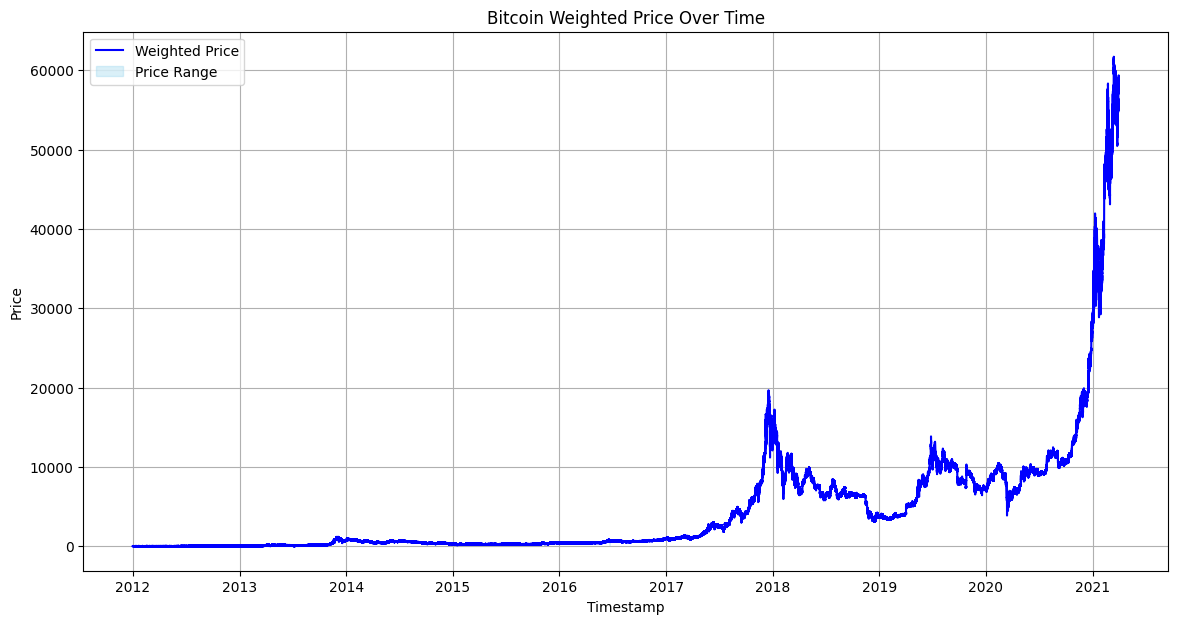

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(data['Timestamp'], data['Weighted_Price'], color='blue', label='Weighted Price')
plt.fill_between(data['Timestamp'], data['Low'], data['High'], color='skyblue', alpha=0.3, label='Price Range')
plt.title('Bitcoin Weighted Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**Calculate the number of missing values in each column**

**This code generates a scatter plot comparing Bitcoin's high and low prices, providing a visual representation of their relationship.**

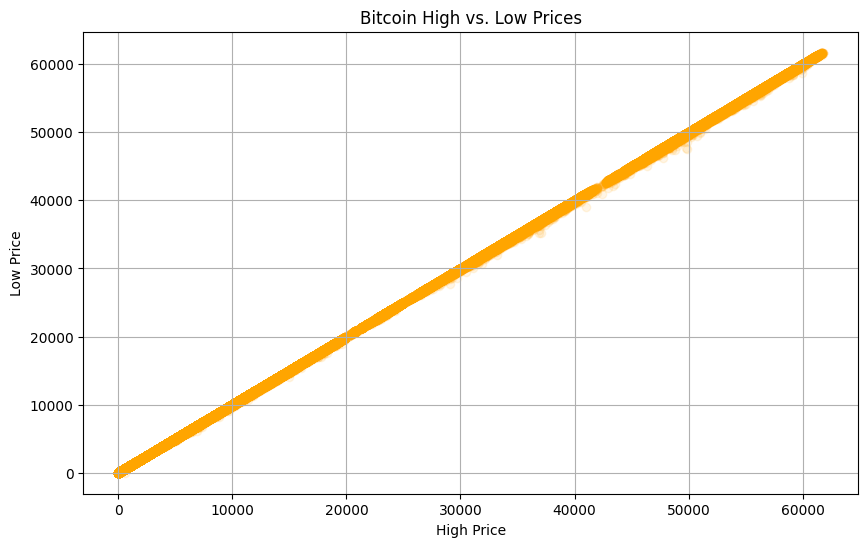

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['High'], data['Low'], color='orange', alpha=0.1)
plt.title('Bitcoin High vs. Low Prices')
plt.xlabel('High Price')
plt.ylabel('Low Price')
plt.grid(True)
plt.show()

In [ ]:
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64


**Calculate the number of unique values in each column**

In [ ]:
unique_values = data.nunique()
print("Unique Values:")
print(unique_values)

Unique Values:
Timestamp            4857377
Open                 1059732
High                 1030826
Low                  1046536
Close                1058685
Volume_(BTC)         3181865
Volume_(Currency)    3562603
Weighted_Price       3046022
dtype: int64


**Calculate the correlation matrix**

In [ ]:
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                   Timestamp      Open      High       Low     Close  \
Timestamp           1.000000  0.650719  0.650644  0.650803  0.650714   
Open                0.650719  1.000000  0.999999  0.999999  0.999999   
High                0.650644  0.999999  1.000000  0.999998  0.999999   
Low                 0.650803  0.999999  0.999998  1.000000  0.999999   
Close               0.650714  0.999999  0.999999  0.999999  1.000000   
Volume_(BTC)       -0.103926 -0.051860 -0.051717 -0.052040 -0.051877   
Volume_(Currency)   0.228190  0.344074  0.344498  0.343541  0.344036   
Weighted_Price      0.650737  0.999999  0.999999  1.000000  1.000000   

                   Volume_(BTC)  Volume_(Currency)  Weighted_Price  
Timestamp             -0.103926           0.228190        0.650737  
Open                  -0.051860           0.344074        0.999999  
High                  -0.051717           0.344498        0.999999  
Low                   -0.052040           0.343541     

**This code will generate a heatmap displaying the correlation coefficients between different numerical columns in the data DataFrame. Adjust the figsize, colormap (cmap), and other parameters as needed to customize the appearance of the heatmap.**

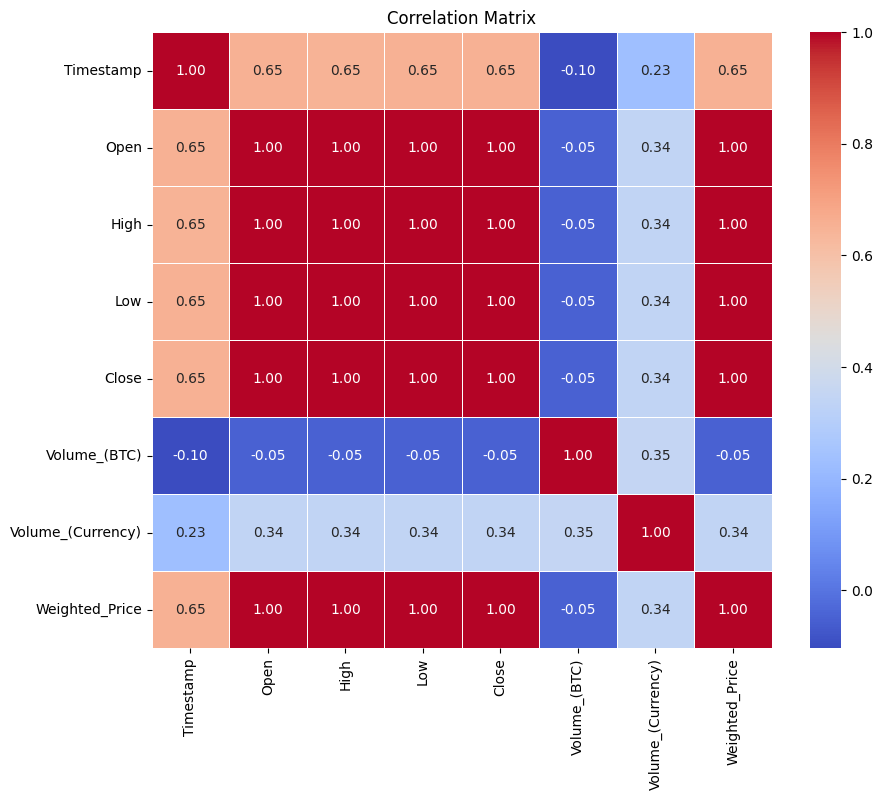

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Little preprocessing required, replacing the NaN values with zeroes and previous data.

In [ ]:
# First thing is to fix the data for bars/candles where there are no trades.
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)


**Display the first few rows of the filled DataFrame**

In [ ]:
print("DataFrame after filling missing values:")
print(data.head())

DataFrame after filling missing values:
                  Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00+00:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00+00:00  4.39  4.39  4.39   4.39      0.000000   
2 2011-12-31 07:54:00+00:00  4.39  4.39  4.39   4.39      0.000000   
3 2011-12-31 07:55:00+00:00  4.39  4.39  4.39   4.39      0.000000   
4 2011-12-31 07:56:00+00:00  4.39  4.39  4.39   4.39      0.000000   

   Volume_(Currency)  Weighted_Price  
0                2.0            4.39  
1                0.0            4.39  
2                0.0            4.39  
3                0.0            4.39  
4                0.0            4.39  


### Creating Weekly Rows for the Data Visualization

In [ ]:
# create valid date range
start = datetime.datetime(2015, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2018, 11, 11, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
weekly_rows.head()



Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0 2015-01-05 00:00:00+00:00  321.00  321.00  321.00  321.00      1.736972   
1 2015-01-12 00:00:00+00:00  272.45  305.00  272.45  291.10    175.837078   
2 2015-01-19 00:00:00+00:00  267.10  267.37  267.10  267.19      3.862525   
3 2015-01-26 00:00:00+00:00  216.01  216.33  216.01  216.17      8.473313   
4 2015-02-02 00:00:00+00:00  274.76  274.76  273.47  274.04      5.240000   

   Volume_(Currency)  Weighted_Price  
0         557.568147      321.000000  
1       50502.066285      287.209426  
2        1031.958849      267.172066  
3        1832.357664      216.250435  
4        1433.884424      273.642066

Lets visualize Historical Bitcoin Prices (2015-2018)

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()


In [ ]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices (2015-2018) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3]
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")


Lets visualize Historical Bitcoin Market Volume (2015-2018)

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2015-2018) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")


In [ ]:
#BTC Volume vs USD visualization
trace = go.Scattergl(
    y = weekly_rows['Volume_(BTC)'].astype(float),
    x = weekly_rows['Weighted_Price'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='compare_webgl')
fig.show(renderer="colab")


# **Time Series Forecasting**

Time Series data is an experimental data which has been observed at different points in time (usually evenly spaced, like once a day or once an hour or once a minute). For example, the data of airline ticket sales per day is a time series. However, just because a series of events has a time element does not automatically make it a time series, such as the dates of major airline disasters, which are randomly spaced and are not time series. These types of random processes are known as point process.

Time Series have several key features such as trend, seasonality, and noise.Forecasting is the process of making predictions of the future, based on past and present data.

Here in this kernel, we attempt to perform Time Series Analysis on the Historic Bitcoin Price data. We can easily see from the **Data Exploration** section, that the Bitcoin prices were quite volatile and inconsistent over the years.  Its very hard to perform Time series analysis on such volatile data. But here we try to explore the different Time series forecasting models. All the models used in this Kernel are very basic, there is scope of more complex and better performing models.  

*  Time Series forecasting with LSTM
* Time Series forecasting with XGBoost
* Time Series forecasting with Facebook Prophet
* Time Series forecasting with ARIMA



## **Predicting using LSTM**

In the first section, we use LSTM  (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs [here.](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [ ]:
#load the dataset
data = pd.read_csv('/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',parse_dates=[0], date_parser=dateparse)
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)


For the train and test, we take '25-Jun-2018' as the split date.  There was a considerable dip in Bitcoin prices between the June-July period 2018.  If we check the historical prices the seasonal market started going up from this date after reaching the lowest, though the price reached much lower $5972 on June 29th 2018. After reaching the historic 20K mark on December 18th, there were several dips and market price was recorrected every time. Read more about [Bitcoin dips.](http://https://news.bitcoin.com/data-reveals-reasons-behind-bitcoins-big-dip/)

In [ ]:
# split data
split_date = '25-Jun-2020'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()


In [ ]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))


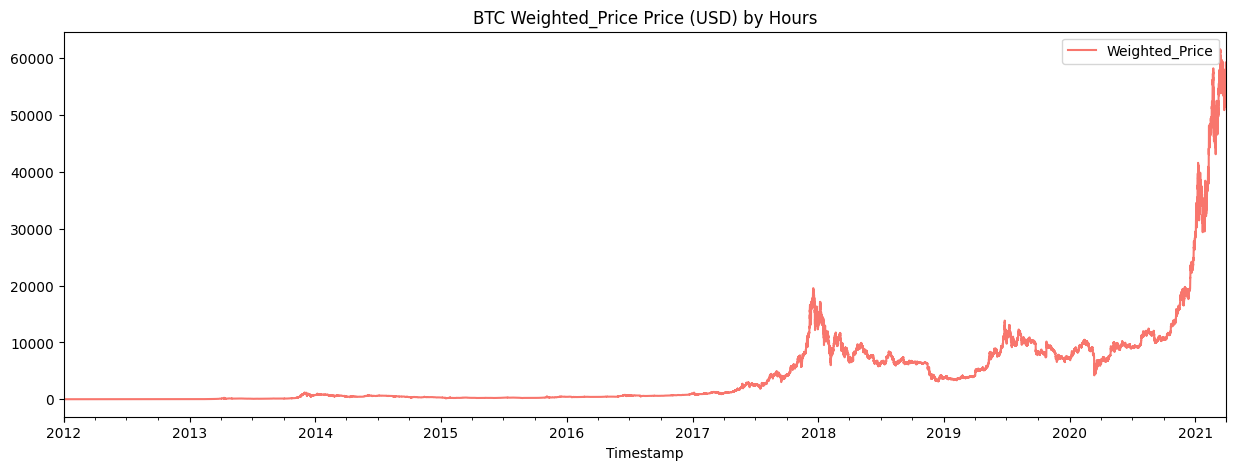

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

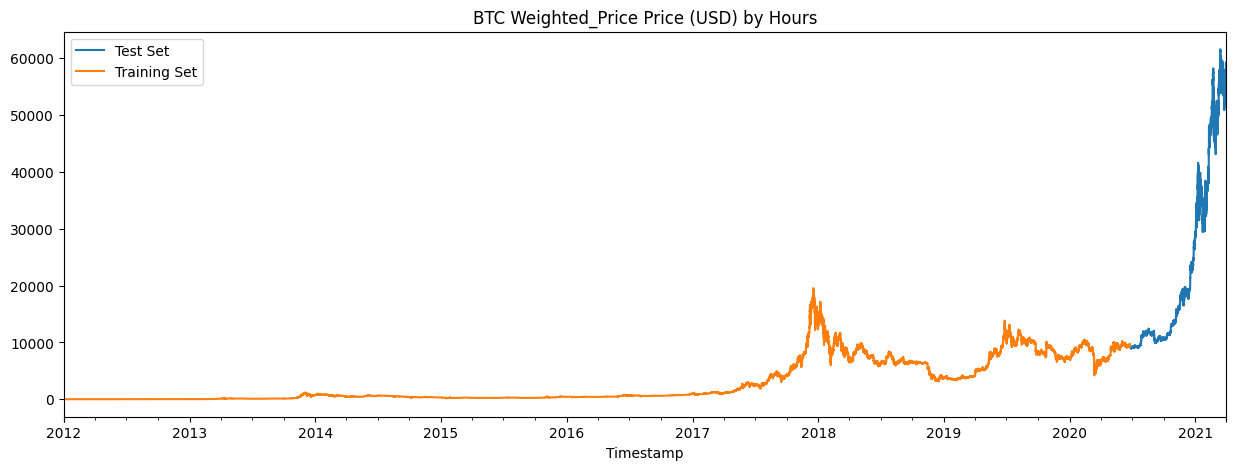

In [ ]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

We will use a Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from keras.callbacks import LearningRateScheduler, Callback
from keras.optimizers import SGD
import keras.backend as K

# Callback to print the learning rate
class LearningRatePrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(K.get_value(self.model.optimizer.lr))
        print(f"\nLearning rate for epoch {epoch+1} is {lr:.5f}")

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr

# Create the enhanced model
def create_enhanced_model():
    model = Sequential()
    model.add(Conv1D(filters=50, kernel_size=3, strides=1, activation='relu', padding='causal', input_shape=(1, 1)))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(40))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=SGD(learning_rate=5e-2, momentum=0.9), metrics=['mae'])
    return model

# Instantiate the model
model = create_enhanced_model()

# Learning rate scheduler and printer callbacks
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
lr_printer = LearningRatePrinter()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=50, verbose=2, callbacks=[lr_scheduler, lr_printer])

# Print the model summary to verify the architecture
model.summary()



Epoch 1: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 1/50

Learning rate for epoch 1 is 0.05000
1488/1488 - 12s - loss: 0.0093 - mae: 0.0927 - lr: 0.0500 - 12s/epoch - 8ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 2/50

Learning rate for epoch 2 is 0.05000
1488/1488 - 8s - loss: 2.0364e-04 - mae: 0.0145 - lr: 0.0500 - 8s/epoch - 6ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 3/50

Learning rate for epoch 3 is 0.05000
1488/1488 - 7s - loss: 1.9089e-04 - mae: 0.0141 - lr: 0.0500 - 7s/epoch - 5ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 4/50

Learning rate for epoch 4 is 0.05000
1488/1488 - 8s - loss: 1.7734e-04 - mae: 0.0138 - lr: 0.0500 - 8s/epoch - 6ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 5/50

Learning rate for epoch 5 is 0.05000
1488/1488 - 7s - loss: 1.6763e-04 -

In [ ]:
# # Importing the Keras libraries and packages
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout
# from keras.layers import Activation


# model = Sequential()
# model.add(LSTM(128,activation="relu",input_shape=(1,1)))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

In [ ]:
model.summary()

In [ ]:
# # Making the predictions
# test_set = data_test.values
# inputs = np.reshape(test_set, (len(test_set), 1))
# inputs = sc.transform(inputs)
# inputs = np.reshape(inputs, (len(inputs), 1, 1))
# predicted_BTC_price = model.predict(inputs)
# predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

210/210 [==============================] - 2s 3ms/step


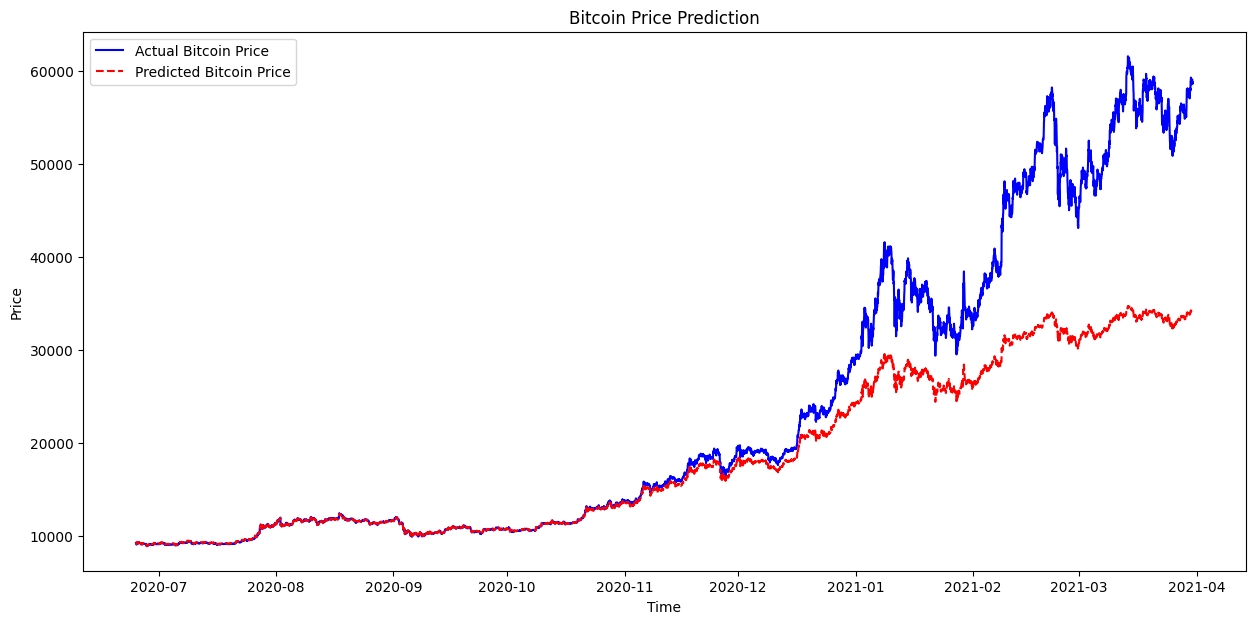

In [ ]:
import matplotlib.pyplot as plt

# Assuming data_test is your test data and sc is the scaler used during training

# Preprocess the test data
test_set = data_test['Weighted_Price'].values.reshape(-1, 1)

# Apply the same scaler used for training data
inputs = sc.transform(test_set)

# Reshape to match the expected input shape of the model
inputs = inputs.reshape(-1, 1, 1)

# Make predictions
predicted_BTC_price = model.predict(inputs)

# Inverse transform to get the actual values
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price).reshape(-1)

# Plotting the results
plt.figure(figsize=(15,7))
plt.plot(data_test.index, data_test['Weighted_Price'], color='blue', label='Actual Bitcoin Price')
plt.plot(data_test.index, predicted_BTC_price, color='red', linestyle='--', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp','Weighted_Price','lstm']]

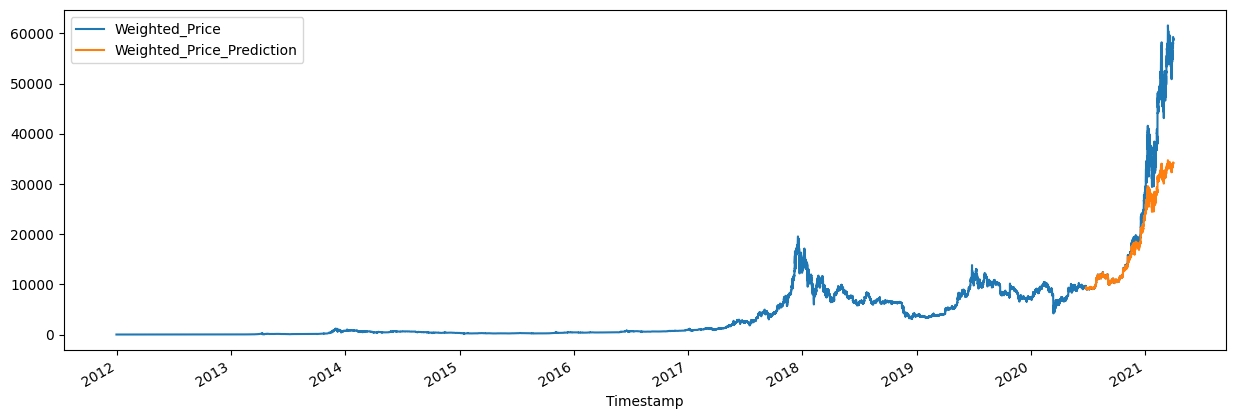

In [ ]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

The MSE is 82813075.16850705 and MAE is 4994.079171543446

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

82813075.16850705

In [ ]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])
# Root Mean Squared Error (RMSE)
lstm_rmse = np.sqrt(lstm_mse)

4994.079171543446

We can clearly see the entire model is over-fitted.

In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/model_data_to_2020')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/model_data_to_2020/
saved_model/model_data_to_2020/variables/
saved_model/model_data_to_2020/variables/variables.data-00000-of-00001
saved_model/model_data_to_2020/variables/variables.index
saved_model/model_data_to_2020/saved_model.pb
saved_model/model_data_to_2020/fingerprint.pb
saved_model/model_data_to_2020/keras_metadata.pb
saved_model/model_data_to_2020/assets/
saved_model/my_model_water_level/
saved_model/my_model_water_level/variables/
saved_model/my_model_water_level/variables/variables.data-00000-of-00001
saved_model/my_model_water_level/variables/variables.index
saved_model/my_model_water_level/saved_model.pb
saved_model/my_model_water_level/fingerprint.pb
saved_model/my_model_water_level/keras_metadata.pb
saved_model/my_model_water_level/assets/


## **Time Series forecasting using ARIMA**

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.
This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA is one of the mostly used techniques for Time Series analysis. In Python,  ARIMA based forecasting models can be created either using AutoARIMA[(Pyramid ARIMA)](https://pypi.org/project/pyramid-arima/) or [StatsModel ](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html). Here we will be using StatsModel as Kaggle do not support Pyramid ARIMA till now.

In [ ]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In [ ]:
data = pd.read_csv('/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',parse_dates=[0], date_parser=dateparse)

In [ ]:
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)
data['Volume_(BTC)'].fillna(method='ffill', inplace=True)
data['Volume_(Currency)'].fillna(method='ffill', inplace=True)

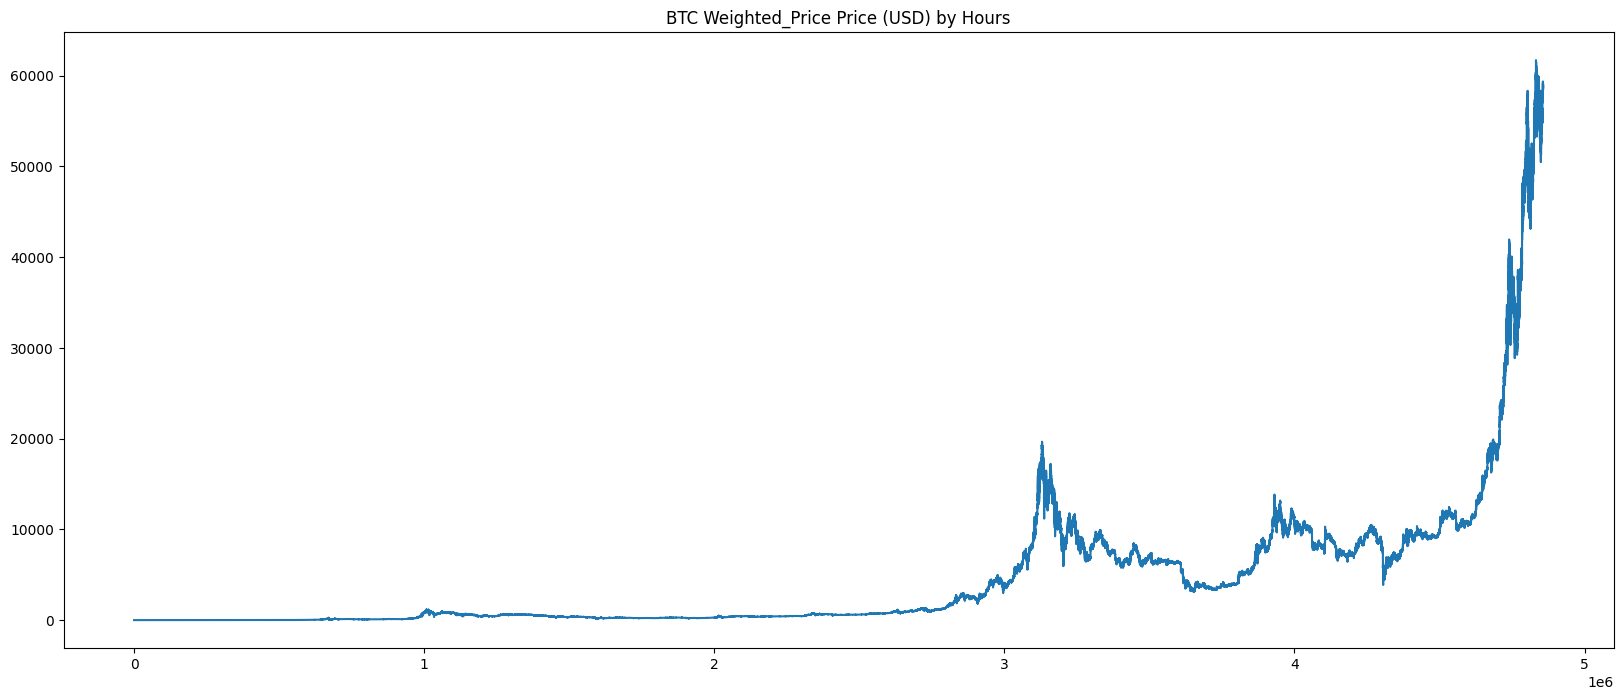

In [ ]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Hours')
plt.plot(data.Weighted_Price, '-', label='By Hours')

In previous sections of LSTM,XGBoost and Prophet, we used hourly data to train the model. But here we will use the monthly data (for Seasonality).

In [ ]:
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

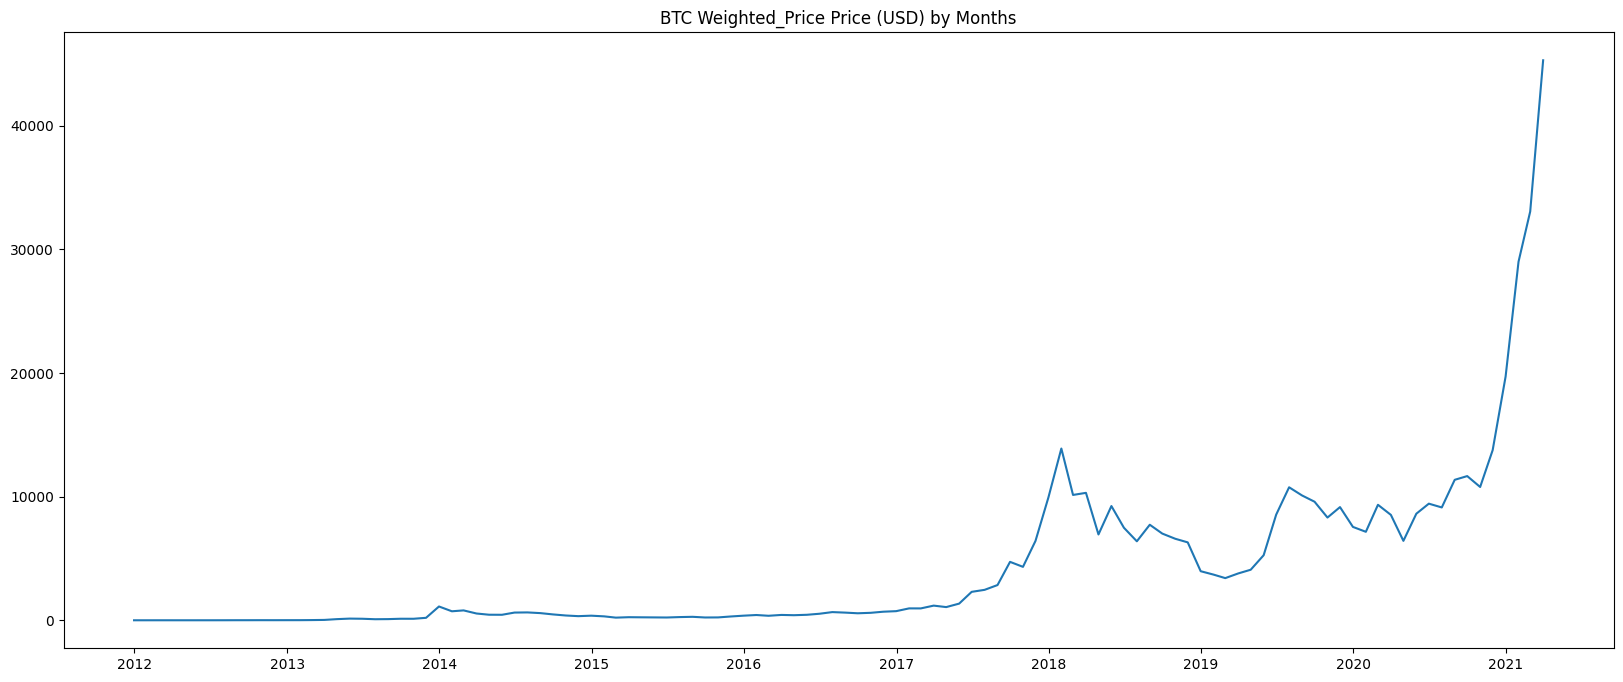

In [ ]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Months')
plt.plot(data.Weighted_Price, '-', label='By Months')

Decomposition

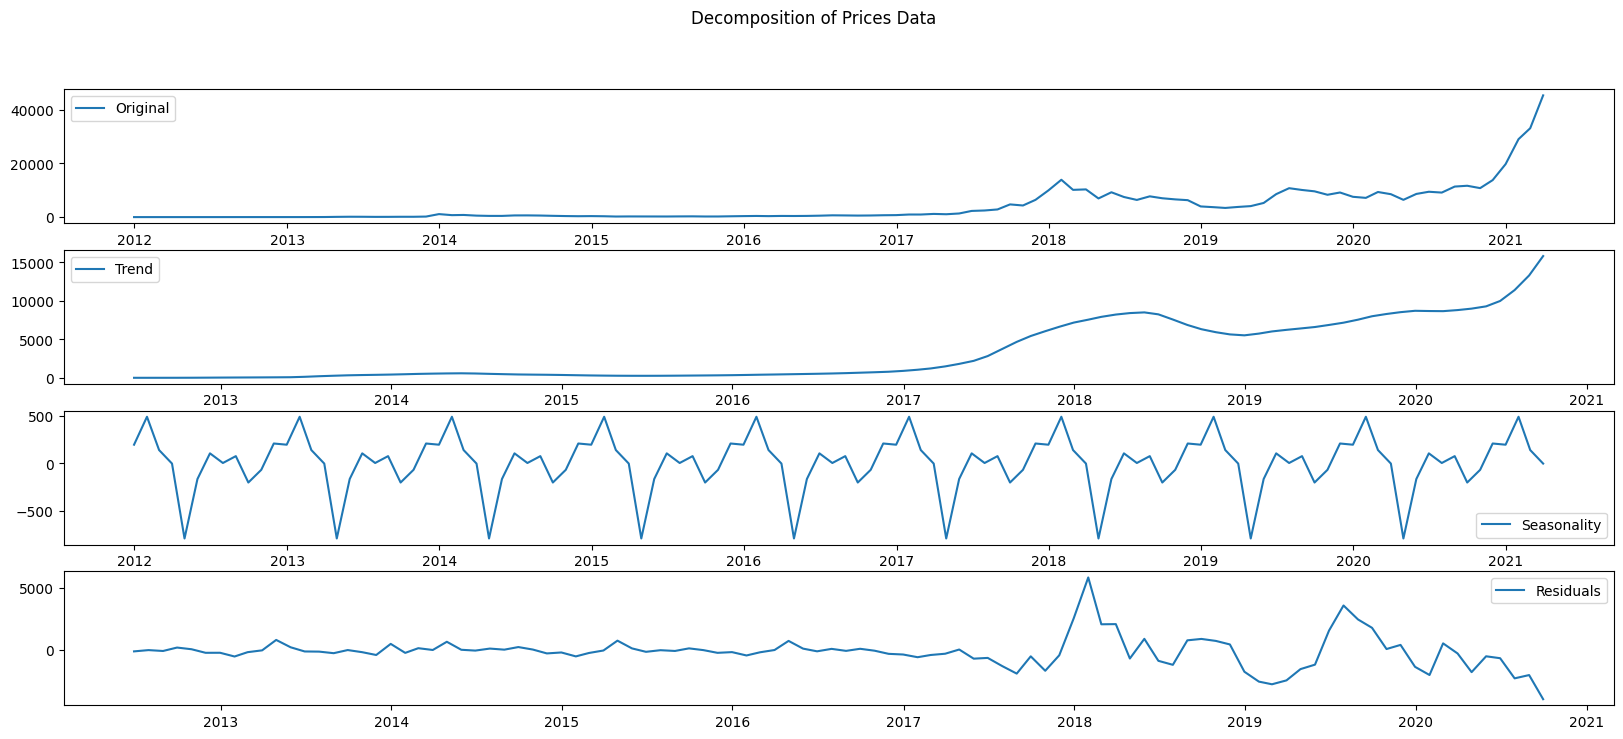

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data.Weighted_Price)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Weighted_Price)[1])

Dickey–Fuller test: p=0.999084


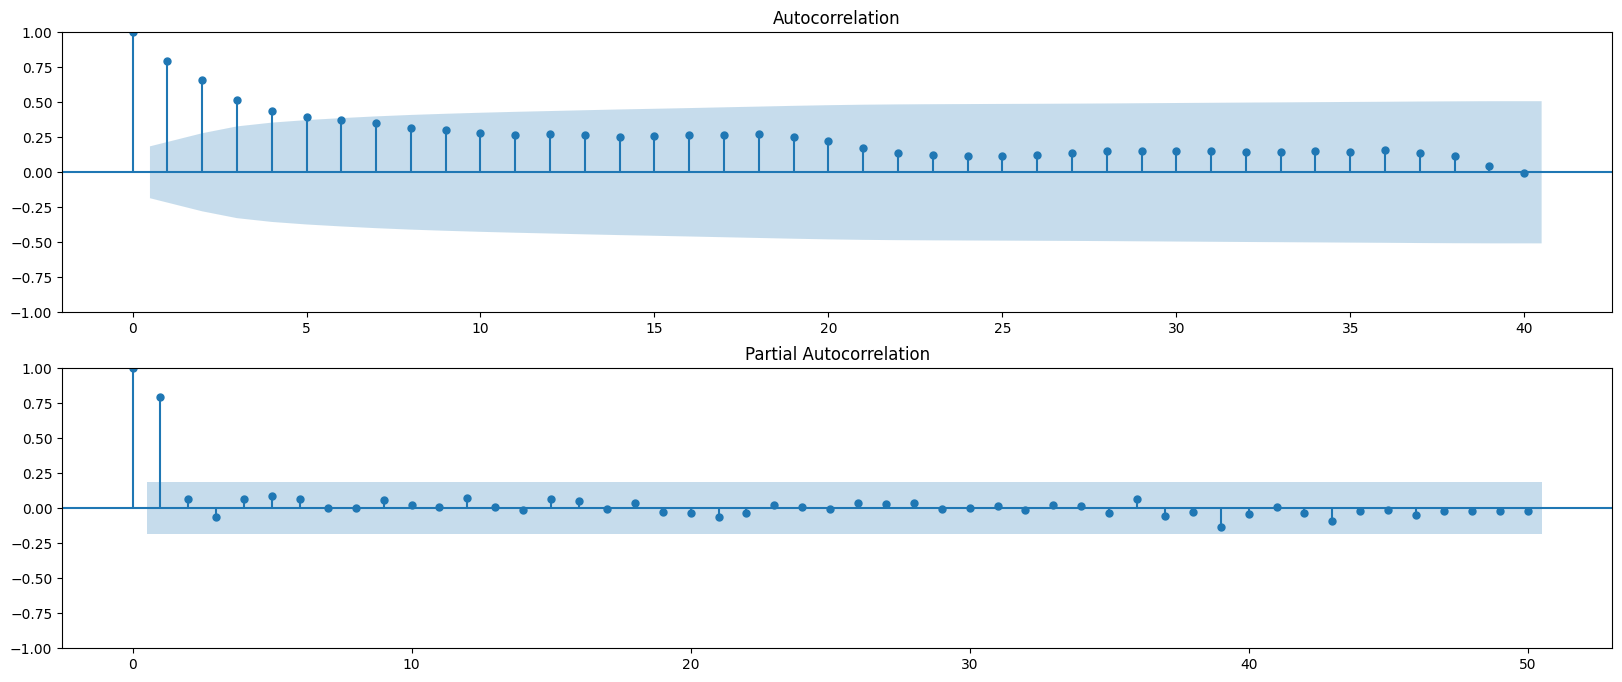

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.Weighted_Price, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.Weighted_Price, ax=pyplot.gca(), lags=50)
pyplot.show()

Here's the Statespace ARIMA Model, the best model is selected using different parameters.

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.Weighted_Price, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
40  (2, 0, 2, 0)  1312.410259
41  (2, 0, 2, 1)  1313.765417
46  (2, 1, 2, 0)  1314.063597
52  (2, 2, 2, 0)  1315.306534
47  (2, 1, 2, 1)  1315.384819
                                     SARIMAX Results                                      
Dep. Variable:                     Weighted_Price   No. Observations:                  112
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -651.205
Date:                            Sat, 01 Jun 2024   AIC                           1312.410
Time:                                    09:17:14   BIC                           1323.863
Sample:                                12-31-2011   HQIC                          1316.974
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

Dickey–Fuller test:: p=0.000000


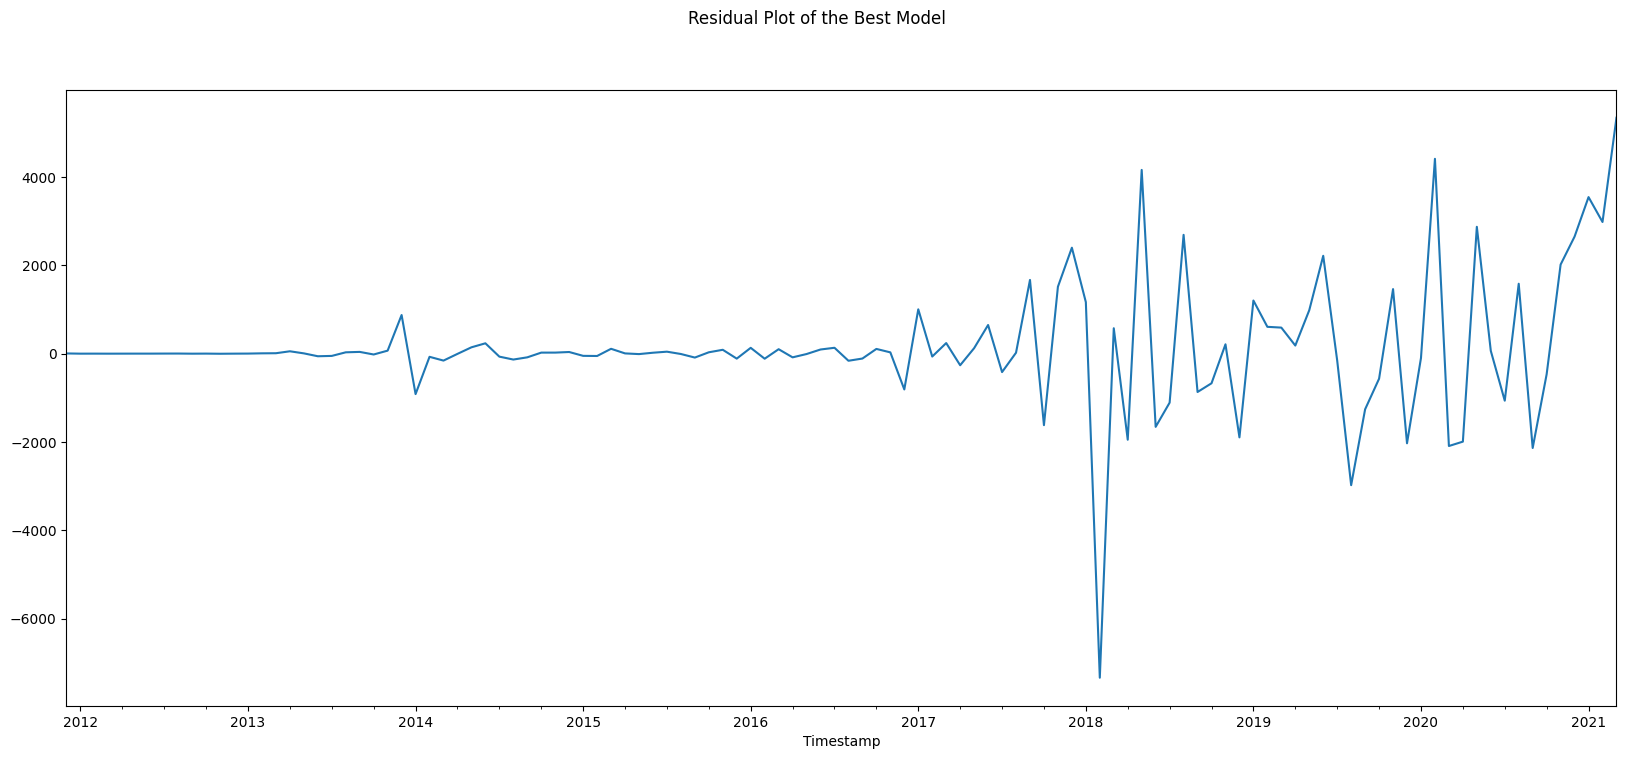

In [ ]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

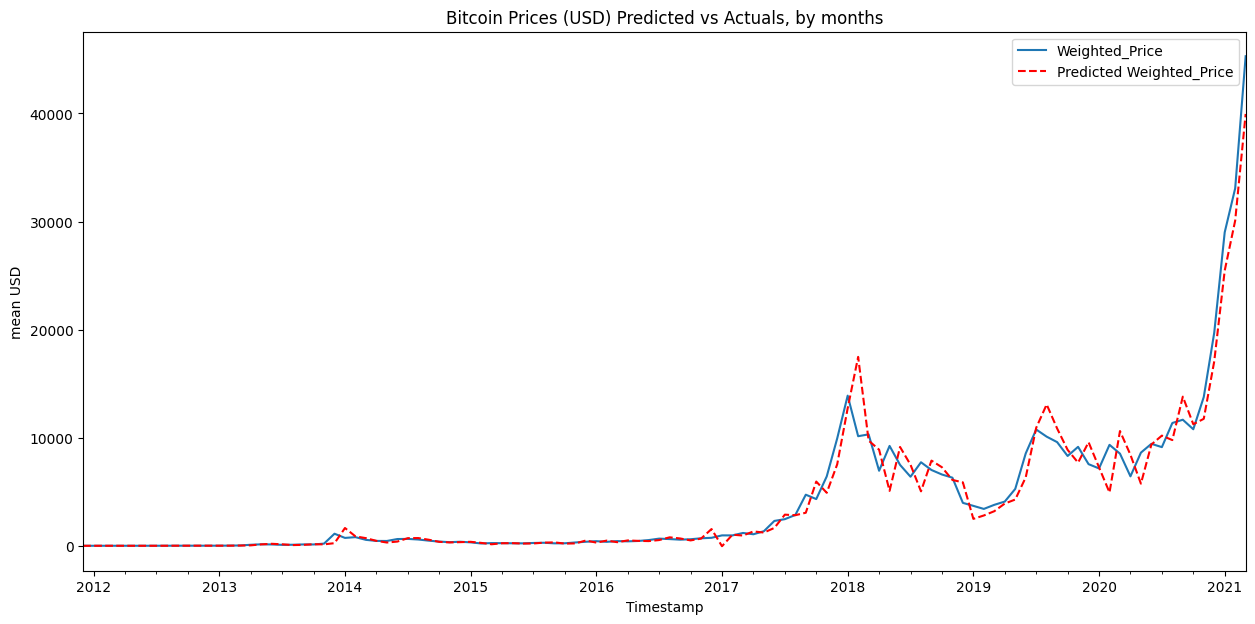

In [ ]:
df_month2 = data[['Weighted_Price']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=200)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

In [ ]:
# Calculate metrics
actual = df_month2['Weighted_Price'][0:201]  # Adjust the range to match the prediction
predicted = df_month2['forecast'][0:201]  # Adjust the range to match the actual data

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 2153610.4672
Mean Absolute Error (MAE): 780.9072
Root Mean Squared Error (RMSE): 1467.5185


## LSTM and ARIMA Comparation

LSTM Model Metrics
Mean Squared Error (MSE): 82813075.1685
Mean Absolute Error (MAE): 4994.0792
Root Mean Squared Error (RMSE): 9100.1690

ARIMA Model Metrics
Mean Squared Error (MSE): 2153610.4672
Mean Absolute Error (MAE): 780.9072
Root Mean Squared Error (RMSE): 1467.5185


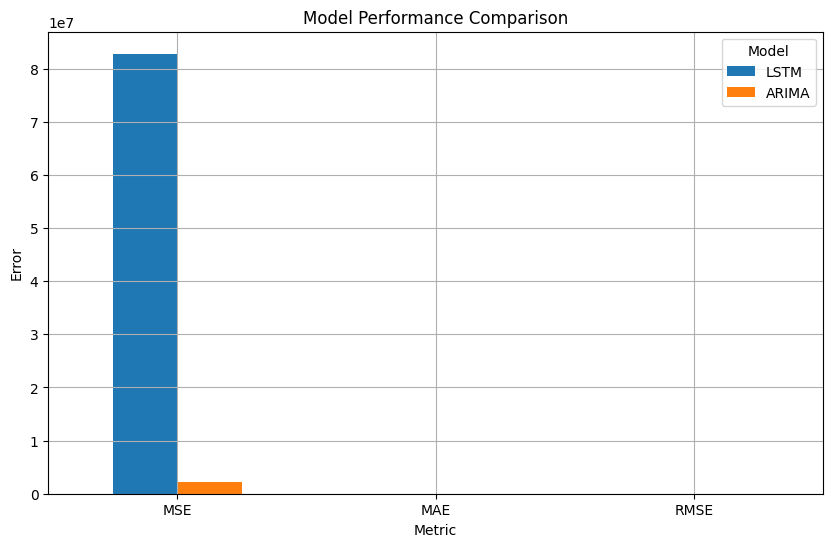

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming data_test and df_month2 are already defined and contain the necessary columns

# LSTM Model Metrics
lstm_mse = mean_squared_error(y_true=data_test['Weighted_Price'], y_pred=data_test['Weighted_Price_Prediction'])
lstm_mae = mean_absolute_error(y_true=data_test['Weighted_Price'], y_pred=data_test['Weighted_Price_Prediction'])
lstm_rmse = np.sqrt(lstm_mse)

# ARIMA Model Metrics
actual = df_month2['Weighted_Price'][0:201]  # Adjust the range to match the prediction
predicted = df_month2['forecast'][0:201]  # Adjust the range to match the actual data

arima_mse = mean_squared_error(actual, predicted)
arima_mae = mean_absolute_error(actual, predicted)
arima_rmse = np.sqrt(arima_mse)

print("LSTM Model Metrics")
print(f"Mean Squared Error (MSE): {lstm_mse:.4f}")
print(f"Mean Absolute Error (MAE): {lstm_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.4f}")

print("\nARIMA Model Metrics")
print(f"Mean Squared Error (MSE): {arima_mse:.4f}")
print(f"Mean Absolute Error (MAE): {arima_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {arima_rmse:.4f}")

# Prepare data for plotting
metrics = ['MSE', 'MAE', 'RMSE']
lstm_metrics = [lstm_mse, lstm_mae, lstm_rmse]
arima_metrics = [arima_mse, arima_mae, arima_rmse]

# Create a DataFrame for easier plotting
df_metrics = pd.DataFrame({
    'Metric': metrics,
    'LSTM': lstm_metrics,
    'ARIMA': arima_metrics
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_metrics.plot(x='Metric', kind='bar', ax=ax)
plt.title('Model Performance Comparison')
plt.ylabel('Error')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(title='Model')
plt.show()


We can see how the above models perform with Historic Bitcoin Price data.  The prediction is not good. The Bitcoin prices are very volatile and very random, and is often influenced by external factors (or news) such as Cryptocurrency regulations, Investments or simple rumours on social media. We need additional data from news or social media to make these models perform better and more accurately.

Note : Will add GARCH in the next version.

Some nice reads for further knowledge in Time Series Forecasting :-

1. https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
1. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
1. https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
1. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
1. https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
1. https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f
1. https://mlwhiz.com/blog/2017/12/26/How_to_win_a_data_science_competition/
1. https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/
